<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Прогнозирование-значения-y(t)-предыдущим-значением-ряда,-то-есть-y(t-1)" data-toc-modified-id="Прогнозирование-значения-y(t)-предыдущим-значением-ряда,-то-есть-y(t-1)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Прогнозирование значения y(t) предыдущим значением ряда, то есть y(t-1)</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Модель-градиентного-бустинга-(CatBoost)" data-toc-modified-id="Модель-градиентного-бустинга-(CatBoost)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель градиентного бустинга (CatBoost)</a></span></li></ul></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование количества заказов такси на следующий час

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно построить модель для прогнозирования количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке не должно превышать 48.

Примерный план работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Создать тестовую выборку объёмом 10% от общей.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [85]:
import pandas as pd
# отображение ВСЕХ столбцов
pd.options.display.max_columns = None

import numpy as np
import matplotlib.pyplot as plt

# модуль для разделения выборки на части и подбора гиперпараметров
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# алгоритм линейной регрессии
from sklearn.linear_model import LinearRegression

# алгоритм градиентного бустинга
from catboost import CatBoostRegressor

# функции расчёта метрик
from sklearn.metrics import mean_squared_error as mse

# функиця разделения выборки на составляющие: тренд, сезонность и остаток
from statsmodels.tsa.seasonal import seasonal_decompose

In [86]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

# Сортируем данные по времени
df.sort_index(inplace=True)

display(df.head())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Вывод**. В таблице представлены данные о количестве заказов с временным интервалом в 10 мин. Выполним ресемплирование по одному часу.

In [87]:
df = df.resample('1H').sum()
# df.head()

# Анализ данных

Разложим временной ряд на составляющие: тренд, сезонность и остаток декомпозиции (шум).

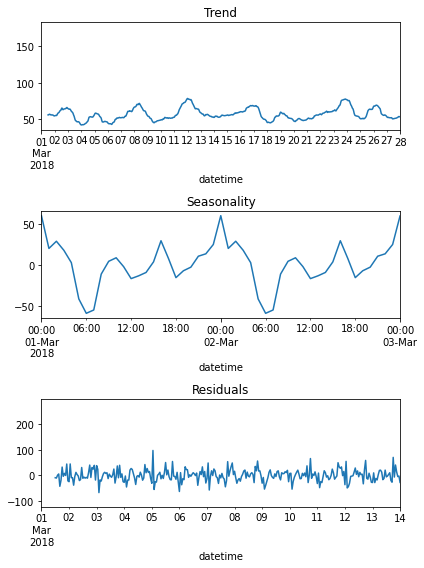

In [88]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(xlim=('2018-03-01','2018-03-28'))
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(xlim=('2018-03-01','2018-03-03'))
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(xlim=('2018-03-01','2018-03-14'))
plt.title('Residuals')

plt.tight_layout()

**Выводы**. 
1. В данных наблюдается восходящий тренд. Временной ряд не является стационарным. 
2. Сезонность характеризуется периодом, равным одним суткам. Ширину "окна" для сглаживания данных лучше брать кратной суткам.

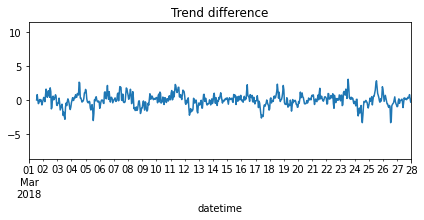

In [89]:
# Чтобы ряд сделать стационарным, найдём разности его значений
df['difference'] = df['num_orders'] - df['num_orders'].shift()

# Удалим первую строку с пропуском
df.dropna(axis=0, inplace=True)

decomposed = seasonal_decompose(df['difference'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(xlim=('2018-03-01','2018-03-28'))
plt.title('Trend difference')

# plt.subplot(312)
# decomposed.seasonal.plot(xlim=('2018-03-01','2018-03-03'))
# plt.title('Seasonality difference')

# plt.subplot(313)
# decomposed.resid.plot(xlim=('2018-03-01','2018-03-14'))
# plt.title('Residuals difference')

plt.tight_layout()

**Вывод**. Разности значений 'num_orders' образуют более стационарный ряд. Посторим модель прогнозирования разностей.

## Обучение модели

In [90]:
# Создадим дополнительные обучающие признаки

def make_features(df, max_lag, rolling_mean_size):
#    df['year'] = df.index.year
#    df['month'] = df.index.month
#    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['difference'].shift(lag)

    df[f'rolling_mean_{rolling_mean_size}'] = (
                                               df['difference'].shift()
                                                               .rolling(rolling_mean_size)
                                                               .mean()
                                               )
    # Удалим строки с пропусками
    df.dropna(axis=0, inplace=True)

make_features(df, 1, 24)

In [91]:
# Отделим целевой признак от остальных.
x = df.drop(['num_orders', 'difference'], axis=1)
y = df[['difference', 'num_orders']]

# Отделим 10% данных для тестовой выборки.
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    x, y, test_size=0.10, shuffle=False)

# Создадим обучающую и валидационную выборки.
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, y_train_valid, test_size=0.11, shuffle=False)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(3516, 4)
(435, 4)
(440, 4)


In [92]:
%%script false --no-raise-error

display(
        x_test.head(),
        y_test.head()
        )

### Прогнозирование значения y(t) предыдущим значением ряда, то есть y(t-1)

In [93]:
# Получим предсказания
predicted_valid = y_valid['num_orders'].shift()

# Оценим качество модели на валидационной выборке
print("RMSE прогнозов на валидационной выборке", 
       mse(y_valid['num_orders'].iloc[1:], predicted_valid[1:], squared=False))

RMSE прогнозов на валидационной выборке 47.4270966124594


### Линейная регрессия

In [94]:
# Инициализируем модель линейной регрессии
lin_reg = LinearRegression()

# Обучим модель на тренировочной выборке
lin_reg.fit(x_train, y_train['difference'])

# Получим предсказания модели
predicted_valid = lin_reg.predict(x_valid) + y_valid['num_orders'].shift()

# Оценим качество модели на валидационной выборке
print("RMSE модели линейной регрессии на валидационной выборке:", 
       mse(y_valid['num_orders'].iloc[1:], predicted_valid[1:], squared=False))

RMSE модели линейной регрессии на валидационной выборке: 43.58526558536474


### Модель градиентного бустинга (CatBoost)

In [95]:
# Указываем гиперпараметры алгоритма градиентного бустинга
params = {'eval_metric': 'RMSE',
          'random_state': 12345,
          'verbose': False}

In [96]:
# Варьируемые гиперпараметры
params_search = {'depth': [4, 6],
                 'learning_rate': [0.03, 0.1]}

# Инициализируем модель градиентного бустинга
cat_boost = CatBoostRegressor(**params)

# Делим обучающую выборку на части (фолды)
tscv = TimeSeriesSplit(n_splits=8)

# Указываем параметры алгоритма подбора гиперпараметров 
grid = GridSearchCV(estimator=cat_boost,
                    scoring='neg_mean_squared_error',
                    cv=tscv,
                    param_grid=params_search)

In [97]:
%%time

# Запускаем обучение модели градиентного бустинга с использованием кросс-валидации
grid.fit(x_train, y_train['difference'])

# Определим лучшие гиперпараметры модели
print(f"Гиперпараметры лучшей модели градиентного бустинга: ", 
      grid.best_params_)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Гиперпараметры лучшей модели градиентного бустинга:  {'depth': 4, 'learning_rate': 0.03}
CPU times: user 27 s, sys: 2.44 s, total: 29.5 s
Wall time: 1min 5s


In [98]:
# Инициализируем модель градиентного бустинга c подобранными гиперпараметрами
cat_boost = grid.best_estimator_

# Обучаем модель градиентного бустинга
cat_boost.fit(          x_train, y_train['difference'], 
              eval_set=(x_valid, y_valid['difference']))

# Получаем предсказания модели
predicted_valid = cat_boost.predict(x_valid) + y_valid['num_orders'].shift()

# Оценим качество модели на валидационной выборке
print("RMSE модели градиентного бустинга на валидационной выборке:", 
       mse(y_valid['num_orders'].iloc[1:], predicted_valid[1:], squared=False))

RMSE модели градиентного бустинга на валидационной выборке: 35.06577743510862


**Вывод**. Лучший результат на валидационной выборке показала модель градиентного бустинга CatBoost. Используем её для оценки RMSE на тестовой выборке.

## Тестирование лучшей модели

In [99]:
# Получим предсказания модели
predicted_test = cat_boost.predict(x_test) + y_test['num_orders'].shift()

# Оценим качество модели на тестовой выборке
print("RMSE модели градиентного бустинга на тестовой выборке:", 
       mse(y_test['num_orders'].iloc[1:], predicted_test[1:], squared=False))

RMSE модели градиентного бустинга на тестовой выборке: 46.114606995750734


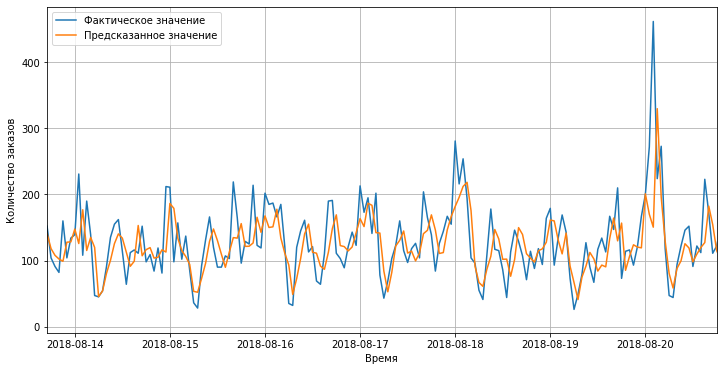

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x_test.index[1:], 
        y_test['num_orders'].iloc[1:],
        label='Фактическое значение')
ax.plot(x_test.index[1:],
        predicted_test[1:],
        label='Предсказанное значение')

ax.legend()
ax.set_xlabel('Время')
ax.set_ylabel('Количество заказов')
ax.grid()
ax.set_xlim([x_test.index[1],x_test.index[24*7+2]])

plt.show()


**Вывод**. Значение метрики RMSE на тестовой выборке не превышает 48. Задача решена.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48